In [1]:
import os
import sys

def add_to_path(new_path: str):
    module_path = os.path.abspath(os.path.join(new_path))
    if module_path not in sys.path:
        sys.path.append(module_path)

is_colab = False

if is_colab:
    !git clone https://github.com/pdkary/Karys.git
    !cd Karys && git fetch && git pull
    !cd Karys && pip install -r requirements.txt --quiet
    add_to_path("Karys/")
    from google.colab import drive
    drive.mount("/content/drive")
    !cd Karys && pip install -r requirements.txt --quiet
else:
    add_to_path("../../")
    !cd ../../ && pip install -r requirements.txt --quiet

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\python39\\Scripts\\jupyter.exe' -> 'c:\\python39\\Scripts\\jupyter.exe.deleteme'

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
from data.configs.TextDataConfig import TextDataConfig
from data.wrappers.TextDataWrapper import TextDataWrapper

if is_colab:
    file_input = "drive/MyDrive/Colab/Language/seinfeld_corpus.txt"
else:
    file_input = "./test_input/corpus.txt"

vocab_size = 10000
sentence_length = 30
output_length = 10

text_config = TextDataConfig(vocab_size, sentence_length, output_length)
text_data_wrapper = TextDataWrapper.load_from_file(file_input, text_config)
text_data_wrapper.show_sentence_n(135)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
sentence in:
 cash get your friends the car the spot the reservation then you're standing around whatta you do you go we gotta be getting back once you're out you wanna get (30,)

sentence out:
 back you wanna go to sleep you wanna get up (10,)


In [3]:
import numpy as np
from models.ModelWrapper import ModelWrapper
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, Activation, LSTM, Embedding, Softmax, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MSE, MSLE, binary_crossentropy, categorical_crossentropy

LR = 4e-5

## Generator
a = 0.08
g_layers = [
    ##128 represents vector space size of the vocabulary
    Embedding(text_config.vocab_size, 128, input_length=sentence_length),
    LSTM(128, return_sequences=True),
    LSTM(256),
    Dense(512), ReLU(),
    Dense(1024), ReLU(),
    Dense(text_config.vocab_size), Softmax()]

g_optimizer = Adam(learning_rate=LR)
g_loss = categorical_crossentropy
#should take in input shape, and give out output shape
text_generator_model = ModelWrapper(text_config.input_shape, text_config.output_shape, g_layers, g_optimizer, g_loss, flatten_input=False)
text_generator_model.build()

## Discriminator
d_layers = [
    Dense(64), ReLU(),
    Dense(256), ReLU(),
    Dense(512), ReLU(),
    Dense(1024), ReLU(),
    Dense(1024), ReLU(),
    Dense(2), Activation("softmax")
]

d_optimizer = Adam(learning_rate=LR)
d_loss = categorical_crossentropy
text_discriminator_model = ModelWrapper(text_config.label_shape,[2],d_layers,d_optimizer,d_loss)
text_discriminator_model.build()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312

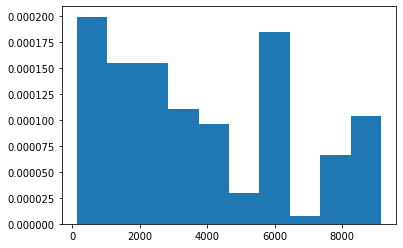

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [4]:
from trainers.TextTrainer import TextTrainer
from plotting.TrainPlotter import TrainPlotter
from plotting.LiveHistogramPlotter import LiveHistogramPlotter
import json

if is_colab:
    file_output = "drive/MyDrive/Colab/Language/output/seinfeld.txt"
else:
    file_output = "./test_output/output.txt"

train_columns = ["Train Gen Loss", "Train Disc Loss", "Test Gen Loss", "Test Disc Loss"]
output_plot = LiveHistogramPlotter()
# loss_plot = TrainPlotter(moving_average_size=100,labels=train_columns)


epochs=1000
batch_size = 3
trains_per_test=4
batches_per_train = 1

text_trainer = TextTrainer(text_generator_model, text_discriminator_model, text_data_wrapper)

gen_test_loss, disc_test_loss = 0,0
for i in range(epochs):
    # loss_plot.start_epoch()
    gen_train_loss, disc_train_loss = text_trainer.train(batch_size, batches_per_train)
    output_fig = output_plot.update(text_trainer.output_histogram)

    if i % trains_per_test == 0 and i != 0:
        gen_test_loss, disc_test_loss = text_trainer.test(5, 1)
        ins = text_data_wrapper.translate_sentences(text_trainer.most_recent_inputs)
        outs = text_data_wrapper.translate_sentences(text_trainer.most_recent_outputs)
        
        get_inout_text = lambda x: "\n".join(["INPUT: ", ins[x], " OUTPUT: ", outs[x]])
        test_output_text = "\n\n".join([get_inout_text(x) for x in range(len(ins))])
        with open(file_output,'w+') as f:
            f.write(test_output_text)

    # loss_plot.batch_update([gen_train_loss, disc_train_loss, gen_test_loss, disc_test_loss])
    # loss_plot.log_epoch()